# Лабораторная работа 4.1 Построение и оценка модели для прогнозирования оттока клиентов

**Тема.** Интерпретация результатов модели для принятия бизнес-решений

**Курс.** Python для анализа данных

**Специальность.** Бизнес-информатика

### Цель работы:
Научиться применять модели машинного обучения (регрессию и классификацию) для решения реальных бизнес-задач, а также интерпретировать полученные результаты для формирования практических рекомендаций и принятия управленческих решений.

---

## Машинное обучение как инструмент бизнес-аналитика

В современном бизнесе данные — это стратегический актив. Способность предсказывать будущее поведение клиентов, оценивать риски и оптимизировать процессы напрямую влияет на прибыльность компании. Машинное обучение (ML) предоставляет для этого мощный инструментарий.

**Сквозной бизнес-кейс.** На протяжении всей этой работы мы будем решать одну из самых классических и важных задач — **прогнозирование оттока клиентов (Customer Churn)** на примере телеком-оператора.

**Почему это важно для бизнеса?**
- **Прямые финансовые потери.** Потерянный клиент — это потерянный доход.
- **Высокая стоимость привлечения.** Привлечь нового клиента в 5-7 раз дороже, чем удержать существующего.

Наша цель — не просто построить модель, которая предсказывает отток, а понять, **как использовать её результаты для реальных действий**: кому из клиентов предложить скидку, на какие факторы обратить внимание, чтобы снизить отток в будущем.

## Часть 1. Подготовка к анализу

Импортируем необходимые библиотеки и загрузим наш датасет.

In [7]:
# Установка библиотек (если требуется)
!pip install pandas numpy matplotlib seaborn scikit-learn -q

# Импорт основных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Импорт инструментов для предобработки данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Импорт моделей
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier

# Импорт метрик для оценки
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, r2_score

# Настройки для визуализаций
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


**Задание 1: Загрузка и первичный осмотр данных**

Загрузите датасет по оттоку клиентов телеком-оператора по предоставленной ссылке. Выведите первые 5 строк (`.head()`) и общую информацию о данных (`.info()`).

In [9]:
# URL датасета
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'

# Ваш код здесь
# 1. Загрузите данные в DataFrame 'df'
df = pd.read_csv(url)

In [10]:
# 2. Выведите первые 5 строк
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [14]:
# 3. Выведите информацию о DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Часть 2. Исследовательский анализ данных (EDA) для бизнес-гипотез

Цель EDA — не просто посмотреть на данные, а найти в них инсайты, которые помогут нам в дальнейшем моделировании и принятии решений.

**Задание 2. Анализ целевой переменной**

Наша целевая переменная для задачи классификации — столбец `Churn` (Отток). Постройте столбчатую диаграмму (`countplot` из seaborn), чтобы визуализировать распределение классов. Сделайте вывод о сбалансированности классов.

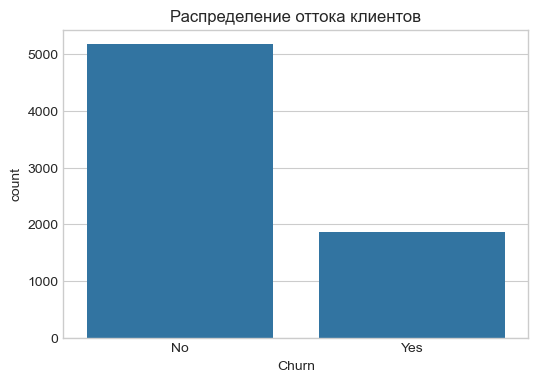

In [18]:
# Ваш код здесь
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Churn')
plt.title('Распределение оттока клиентов')
plt.show()

# Вывод: классы несбалансированы, лояльных клиентов значительно больше, чем ушедших.
# Это нужно будет учитывать при оценке модели.

**Задание 3: Влияние типа контракта на отток**

**Бизнес-гипотеза.** Клиенты с краткосрочными контрактами (Month-to-month) более склонны к оттоку.
Проверьте эту гипотезу, построив `countplot` для столбца `Contract`, разделив его по значениям `Churn` (используйте параметр `hue`).

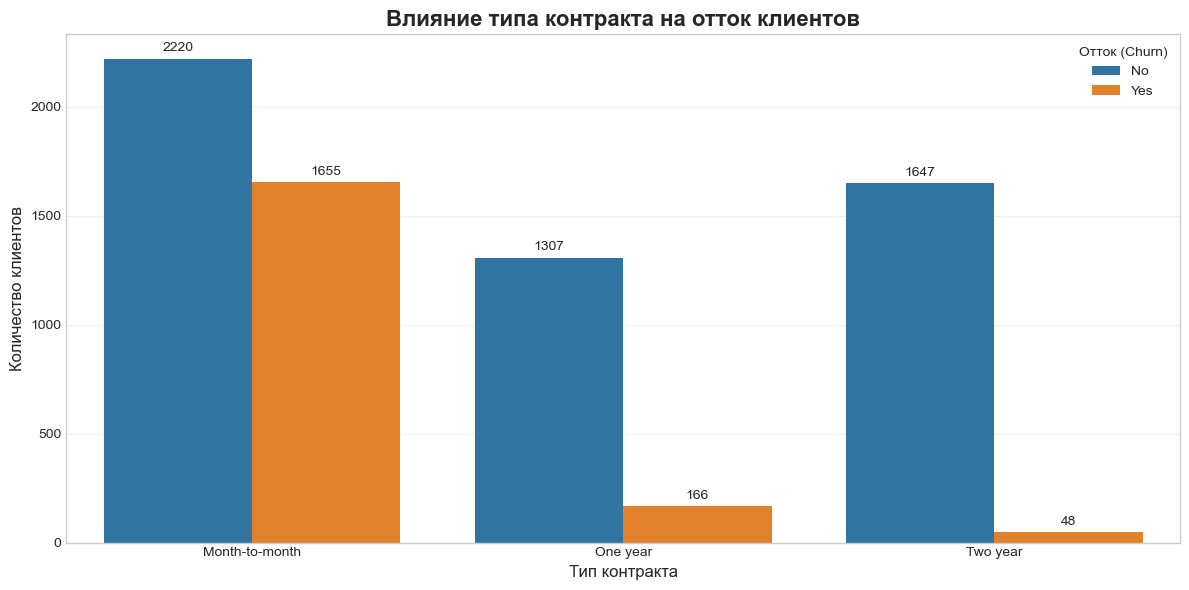

In [21]:
# Ваш код здесь
plt.figure(figsize=(12, 6))

sns.countplot(data=df, x='Contract', hue='Churn', order=['Month-to-month', 'One year', 'Two year'])

plt.title('Влияние типа контракта на отток клиентов', fontsize=16, fontweight='bold')
plt.xlabel('Тип контракта', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.legend(title='Отток (Churn)')
plt.grid(axis='y', alpha=0.3)

# Добавление значений над столбцами
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3)

plt.tight_layout()

**Задание 4. Влияние ежемесячных платежей на отток**

**Бизнес-гипотеза.** Клиенты с более высокими ежемесячными платежами чаще уходят.
Проверьте это, построив `boxplot` (ящик с усами), где по оси X будет `Churn`, а по оси Y — `MonthlyCharges`.

C:\Users\User\AppData\Local\Temp\ipykernel_9196\586711163.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y='MonthlyCharges', palette=['lightblue', 'salmon'])


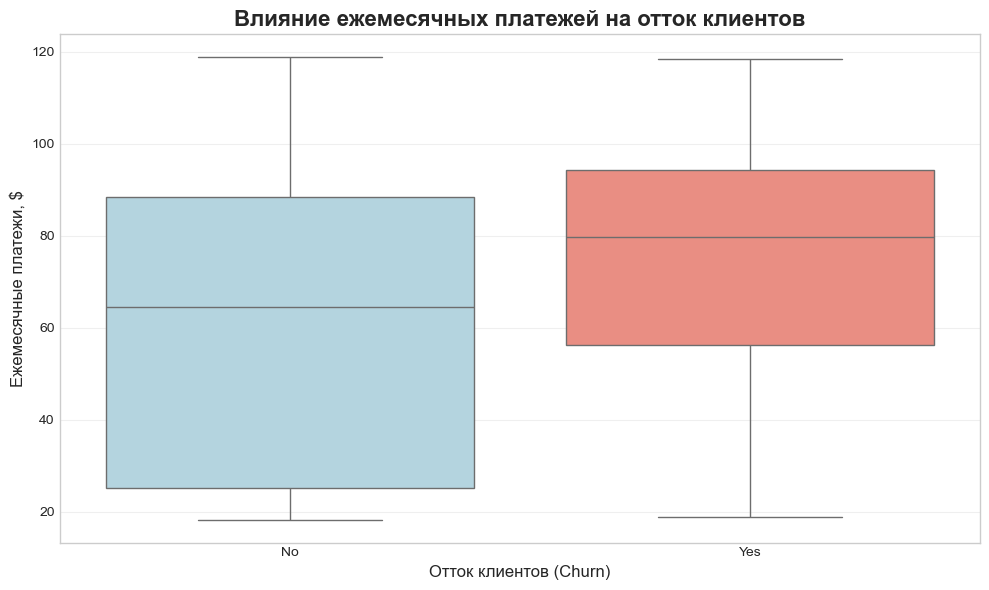

In [30]:
# Ваш код здесь
plt.figure(figsize=(10, 6))

sns.boxplot(data=df, x='Churn', y='MonthlyCharges', palette=['lightblue', 'salmon'])

plt.title('Влияние ежемесячных платежей на отток клиентов', fontsize=16, fontweight='bold')
plt.xlabel('Отток клиентов (Churn)', fontsize=12)
plt.ylabel('Ежемесячные платежи, $', fontsize=12)

ax = plt.gca()

plt.ylim(df['MonthlyCharges'].min() - 5, df['MonthlyCharges'].max() + 5)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Часть 3. Подготовка данных для моделирования (Pre-processing)

Модели машинного обучения работают с числами. Нам нужно преобразовать наши данные: категориальные признаки — в числовые, а числовые — отмасштабировать.

**Задание 5. Предобработка данных**

Выполните следующие шаги:
1. `TotalCharges` имеет тип `object`. Преобразуйте его в числовой с помощью `pd.to_numeric`, а ошибки замените на `NaN` (`errors='coerce'`).
2. Заполните пропуски в `TotalCharges` медианным значением.
3. Целевую переменную `Churn` преобразуйте в 0 и 1.
4. Удалите ненужный для моделирования столбец `customerID`.

In [32]:
# Ваш код здесь
# 1. Преобразование TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 2. Заполнение пропусков
median_total_charges = df['TotalCharges'].median()
df['TotalCharges'].fillna(median_total_charges, inplace=True)

# 3. Преобразование Churn
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 4. Удаление customerID
if "customerID" in df.columns:
    df.drop('customerID', axis=1, inplace=True)
    print(f"Столбец 'customerID' успешно удален")
else:
    print(f"Столбец 'customerID' не найден в DataFrame")


df.info() # Проверка, что все типы данных корректны

Столбец 'customerID' успешно удален
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  Paymen

C:\Users\User\AppData\Local\Temp\ipykernel_9196\3741206955.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(median_total_charges, inplace=True)


**Задание 6. Разделение признаков и создание пайплайна**

1. Определите `X` (все столбцы, кроме `Churn`) и `y` (`Churn`).
2. Разделите `X` и `y` на обучающую и тестовую выборки (`train_test_split`) в соотношении 80/20.
3. Определите списки числовых (`numerical_features`) и категориальных (`categorical_features`) признаков.
4. Создайте пайплайн предобработки `preprocessor` с помощью `ColumnTransformer`, который будет масштабировать числовые признаки (`StandardScaler`) и кодировать категориальные (`OneHotEncoder`).

In [84]:
# Ваш код здесь
# 1. Определение X и y
X = df.drop('Churn', axis=1)
y = df['Churn'] 

# 2. Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42,  
    stratify=y  # Сохраняем пропорции классов
)

# 3. Определение типов признаков
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# 4. Создание ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

print("Пайплайн предобработки успешно создан.")

Пайплайн предобработки успешно создан.


## Часть 4. Задача классификации - Прогнозирование оттока

**Задание 7. Обучение модели логистической регрессии**

Создайте пайплайн `log_reg_pipeline`, который последовательно будет выполнять шаги `preprocessor` и обучать модель `LogisticRegression`. Обучите этот пайплайн на `X_train`, `y_train`.

In [40]:
# Ваш код здесь
log_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        random_state=42,
        max_iter=1000,  
        class_weight='balanced'
    ))
])

log_reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

**Задание 8. Оценка модели и интерпретация для бизнеса**

1. Сделайте предсказания на тестовой выборке (`X_test`).
2. Рассчитайте `accuracy`.
3. Постройте **матрицу ошибок (confusion matrix)** и проинтерпретируйте её с точки зрения бизнеса.

Точность (Accuracy): 0.74


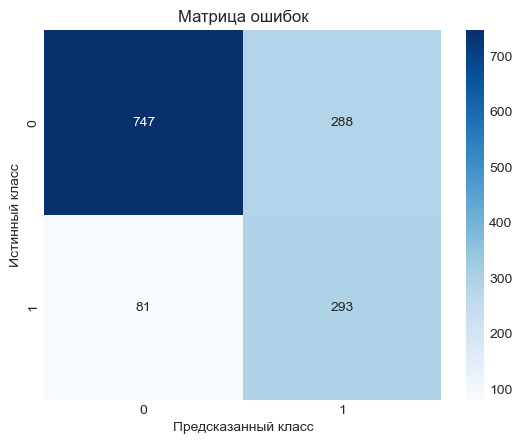

In [43]:
# Ваш код здесь
# 1. Предсказания
y_pred = log_reg_pipeline.predict(X_test)

# 2. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность (Accuracy): {accuracy:.2f}")

# 3. Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

# Интерпретация для бизнеса:
# True Negative (TN, левый верхний угол). Мы правильно определили лояльных клиентов. Это хорошо.
# False Positive (FP, правый верхний угол). Мы ошибочно предсказали отток лояльному клиенту. Бизнес-риск: мы можем потратить деньги на удержание клиента, который и так бы не ушел.
# False Negative (FN, левый нижний угол). Мы не смогли предсказать отток, и клиент ушел. Это самая большая проблема! Мы упустили возможность его удержать и потеряли доход.
# True Positive (TP, правый нижний угол). Мы правильно предсказали отток. Это позволяет нам вовремя принять меры.

<details>
<summary>Нажмите, чтобы увидеть решение</summary>

```python
y_pred = log_reg_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность (Accuracy): {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()
```

</details>

**Задание 9. Анализ важности признаков**

Для линейных моделей, таких как логистическая регрессия, мы можем посмотреть на коэффициенты, чтобы понять, какие признаки наиболее сильно влияют на отток. Извлеките коэффициенты и названия признаков из пайплайна и создайте DataFrame для их анализа.

In [55]:
# Ваш код здесь
coefficients = log_reg_pipeline.named_steps['classifier'].coef_[0]
feature_names = log_reg_pipeline.named_steps['preprocessor'].get_feature_names_out()

coef_df = pd.DataFrame({
    'Признак': feature_names,
    'Коэффициент': coefficients,
})

coef_df['Влияние'] = np.abs(coef_df['Коэффициент'])
coef_df = coef_df.sort_values(by='Влияние', ascending=False)

coef_df

,Признак,Коэффициент,Влияние
1,num__tenure,-1.123595,1.123595
38,cat__Contract_Two year,-0.781255,0.781255
16,cat__InternetService_Fiber optic,0.705337,0.705337
2,num__MonthlyCharges,-0.663583,0.663583
36,cat__Contract_Month-to-month,0.663399,0.663399
15,cat__InternetService_DSL,-0.621009,0.621009
3,num__TotalCharges,0.457218,0.457218
35,cat__StreamingMovies_Yes,0.274978,0.274978
31,cat__StreamingTV_No internet service,-0.274569,0.274569
28,cat__TechSupport_No internet service,-0.274569,0.274569


<details>
<summary>Нажмите, чтобы увидеть решение</summary>

```python
try:
    # Получаем названия закодированных признаков из препроцессора
    feature_names = log_reg_pipeline.named_steps['preprocessor'].get_feature_names_out()
    
    # Получаем коэффициенты из классификатора
    # ИСПРАВЛЕНИЕ: Добавляем [0], так как coef_ возвращает массив вида [[...]], а нам нужен плоский список
    coefficients = log_reg_pipeline.named_steps['classifier'].coef_[0]

    # Создаем DataFrame
    coef_df = pd.DataFrame({'Признак': feature_names, 'Коэффициент': coefficients})
    
    # Рассчитываем абсолютное значение влияния
    coef_df['Влияние'] = np.abs(coef_df['Коэффициент'])
    
    # Сортируем по силе влияния
    coef_df = coef_df.sort_values(by='Влияние', ascending=False)

    print("Топ-10 признаков, влияющих на отток:")
    display(coef_df.head(10))
    
    # Бизнес-интерпретация:
    # Положительные коэффициенты (ближе к верху списка, если они положительные) увеличивают вероятность оттока.
    # Отрицательные коэффициенты уменьшают вероятность оттока (удерживают клиента).
    
except Exception as e:
    print(f"Ошибка при извлечении признаков: {e}")
```

</details>

## Часть 5. Задача регрессии - Прогнозирование ценности клиента (LTV)

Не все клиенты одинаково ценны. Прогнозирование **LTV (Lifetime Value)**, или в нашем случае, `TotalCharges` (общие расходы клиента), поможет понять, на удержание каких клиентов стоит тратить больше усилий.

**Задание 10. Подготовка данных для регрессии**

Целевая переменная теперь — `TotalCharges`.
1. Создайте `X_reg` (все столбцы, кроме `TotalCharges` и `customerID`, `Churn`) и `y_reg` (`TotalCharges`).
2. Разделите данные на обучающую и тестовую выборки.

In [90]:
# Загрузим и очистим данные заново для чистоты эксперимента
df_reg = pd.read_csv(url)
df_reg['TotalCharges'] = pd.to_numeric(df_reg['TotalCharges'], errors='coerce')
df_reg.dropna(inplace=True)

# Ваш код здесь
# 1. Определение X и y
columns_to_exclude = ['TotalCharges', 'customerID', 'Churn']
existing_columns = [col for col in columns_to_exclude if col in df_reg.columns]
X_reg = df_reg.drop(columns=existing_columns, errors='ignore')
y_reg = df_reg['TotalCharges']

# 2. Разделение на train/test
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, 
    y_reg, 
    test_size=0.2,
    random_state=42, 
    shuffle=True
)

**Задание 11. Обучение модели линейной регрессии**

Создайте пайплайн для линейной регрессии, который включает `preprocessor` (тот же, что и раньше, но адаптированный под новые `X`) и модель `LinearRegression`. Обучите его.

In [99]:
# Ваш код здесь
numerical_features = numerical_features.difference(['TotalCharges'])

preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features)
    ]
)

linear_reg_pipeline = Pipeline([
    ("preprocessor", preprocessor_reg),
    ("regressor", LinearRegression())
])

linear_reg_pipeline.fit(X_train_reg, y_train_reg)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['MonthlyCharges', 'SeniorCitizen', 'tenure'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

**Задание 12. Оценка и интерпретация модели регрессии**

1. Сделайте предсказания на `X_test_reg`.
2. Рассчитайте метрики **RMSE** и **R² (R-squared)**.
3. Визуализируйте результат: постройте диаграмму рассеяния (`scatterplot`), где по одной оси будут реальные значения, а по другой — предсказанные.

RMSE: 673.95
R-squared: 0.91


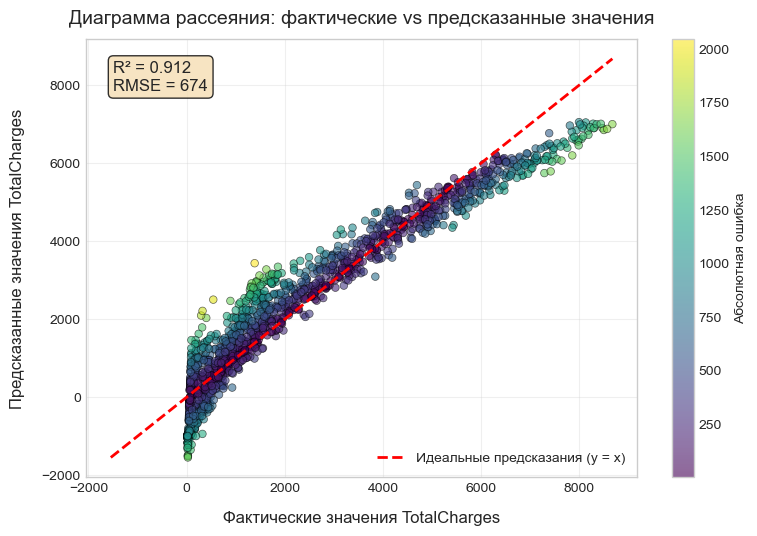

In [129]:
# Ваш код здесь
# 1. Предсказания
y_pred_reg = linear_reg_pipeline.predict(X_test_reg)

# 2. Метрики
rmse_reg = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2_reg = r2_score(y_test_reg, y_pred_reg)

print(f"RMSE: {rmse_reg:.2f}")
print(f"R-squared: {r2_reg:.2f}")

# 3. Визуализация
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
scatter = plt.scatter(y_test_reg, 
                      y_pred_reg, 
                      alpha=0.6, s=30, 
                      c=np.abs(y_test_reg - y_pred_reg),  # Цвет по величине ошибки
                      cmap='viridis',
                      edgecolor='black', linewidth=0.5)

# Линия идеальных предсказаний (y = x)
min_val = min(y_test_reg.min(), y_pred_reg.min())
max_val = max(y_test_reg.max(), y_pred_reg.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Идеальные предсказания (y = x)')

plt.xlabel('Фактические значения TotalCharges', fontsize=12, labelpad=12)
plt.ylabel('Предсказанные значения TotalCharges', fontsize=12, labelpad=12)
plt.title('Диаграмма рассеяния: фактические vs предсказанные значения', fontsize=14, pad=11)
plt.colorbar(scatter, label='Абсолютная ошибка')
plt.grid(alpha=0.3)
plt.legend()

# Добавляем текстовую информацию на график
plt.text(0.05, 
         0.95, 
         f'R² = {r2_reg:.3f}\nRMSE = {rmse_reg:,.0f}',
         transform=plt.gca().transAxes, 
         fontsize=12,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Бизнес-интерпретация:
# RMSE показывает среднюю ошибку прогноза в долларах. R² показывает, какую долю дисперсии целевой переменной объясняет наша модель.
# На графике идеальный прогноз лежал бы на диагональной линии. Мы видим, что модель в целом улавливает тренд, но имеет заметную ошибку.

## Часть 6. Комплексное бизнес-решение

Теперь объединим результаты обеих моделей для принятия взвешенного решения.

**Задание 13. Создание финального DataFrame с прогнозами**

Сделайте предсказания обеими моделями на всем датасете и добавьте их как новые столбцы: `churn_probability` (вероятность оттока) и `predicted_ltv`.

In [144]:
# Задание 13. Создание финального DataFrame с прогнозами
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
df = pd.read_csv(url)

categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
                       'PhoneService', 'MultipleLines', 'InternetService', 
                       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                       'TechSupport', 'StreamingTV', 'StreamingMovies', 
                       'Contract', 'PaperlessBilling', 'PaymentMethod']

numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Предобработка данных
# 1. Преобразуем TotalCharges в числовой тип (в исходных данных он object)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Заполним пропущенные значения в TotalCharges (если есть)
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].mean())

# Разделим признаки и целевую переменную
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn'].map({'Yes': 1, 'No': 0})  # Преобразуем в бинарный формат

# 2. Подготовим пайплайн для предобработки данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)

# Применим предобработку ко всем данным
X_processed = preprocessor.fit_transform(X)

# 3. Разделим данные на обучающую и тестовую выборки (чтобы обучить модели)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Обучим модели (если они еще не обучены)
# Модель для классификации (прогноз оттока)
classifier = LogisticRegression(random_state=42, max_iter=1000)
classifier.fit(X_train, y_train)

# Модель для регрессии (прогноз LTV - Lifetime Value)
# Для регрессии нам нужна другая целевая переменная - например, TotalCharges
y_reg = df['TotalCharges']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_processed, y_reg, test_size=0.2, random_state=42
)

regressor = LinearRegression()
regressor.fit(X_train_reg, y_train_reg)

# 5. Сделаем предсказания на всем датасете
# Вероятность оттока
churn_probabilities = classifier.predict_proba(X_processed)[:, 1]  # Вероятность класса 1 (отток)

# Прогнозируемый LTV (Lifetime Value)
predicted_ltv = regressor.predict(X_processed)

# 6. Добавим прогнозы в исходный DataFrame
df['churn_probability'] = churn_probabilities
df['predicted_ltv'] = predicted_ltv
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,churn_probability,predicted_ltv
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0.610649,29.85
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,0.045763,1889.50
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0.298281,108.15
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,0.029219,1840.75
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0.692591,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,0.123245,1990.50
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,0.134934,7362.90
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,0.388608,346.45
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,0.716942,306.60


**Задание 14. Сегментация клиентов для принятия решений**

**Бизнес-задача.** Нам нужно выделить сегмент клиентов, на удержание которых стоит потратить ресурсы в первую очередь.
**Критерии.**
1. Высокая вероятность оттока (`churn_probability > 0.6`).
2. Высокая прогнозируемая ценность (`predicted_ltv` выше 75-го перцентиля).

Отфильтруйте `df_final` по этим двум критериям и выведите результат.

In [148]:
# Ваш код здесь
df = df[df["churn_probability"] > 0.6]
df = df[df["predicted_ltv"] > df["predicted_ltv"].quantile(0.75)]

df_final = df.copy()
df_final

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,churn_probability,predicted_ltv
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,0.621302,3046.05
38,5380-WJKOV,Male,0,No,No,34,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,106.35,3549.25,Yes,0.617890,3549.25
55,1658-BYGOY,Male,1,No,No,18,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.45,1752.55,Yes,0.779751,1752.55
99,4598-XLKNJ,Female,1,Yes,No,25,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.50,2514.50,Yes,0.648084,2514.50
126,4412-YLTKF,Female,1,No,No,27,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,78.05,2135.50,Yes,0.605376,2135.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6858,2685-SREOM,Female,0,Yes,Yes,25,Yes,Yes,Fiber optic,No,No,Yes,No,No,Yes,Month-to-month,Yes,Electronic check,89.10,2368.40,Yes,0.606460,2368.40
6868,1195-OIYEJ,Male,0,No,No,13,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,91.10,1135.70,Yes,0.718806,1135.70
6914,7142-HVGBG,Male,1,Yes,No,43,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,103.00,4414.30,Yes,0.608526,4414.30
6967,8739-WWKDU,Male,1,No,No,25,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Electronic check,89.50,2196.15,Yes,0.652182,2196.15


---

## Часть 7. Индивидуальный проект - "Построение и оценка модели для прогнозирования оттока клиентов"

**Цель:** Самостоятельно провести полный цикл построения модели оттока для выбранной предметной области, используя знания, полученные в ходе выполнения лабораторной работы.

### Инструкция
1.  **Выберите ваш вариант** из списка ниже.
2.  **Найдите подходящий датасет на Kaggle.** Используйте ключевые слова из вашего варианта (например, `e-commerce customer churn`, `banking churn dataset`). Датасет должен содержать целевую переменную (факт оттока) и не менее 5-7 признаков.
3.  **Проведите полный цикл анализа**, аналогичный тому, что был выполнен в этой тетради:
    *   Загрузка и первичный осмотр данных.
    *   Исследовательский анализ (EDA) с построением 2-3 гипотез и их визуальной проверкой.
    *   Предобработка данных (обработка пропусков, кодирование категорий, масштабирование).
    *   Разделение на обучающую и тестовую выборки.
    *   Построение модели классификации (например, `LogisticRegression` или `RandomForestClassifier`).
    *   Оценка модели (accuracy, confusion matrix) и **интерпретация результатов с точки зрения бизнеса**.
4.  Оформите ваше решение в виде Jupyter Notebook, сохранив все выводы и графики.

### Варианты заданий

1.  **Ритейл (одежда).** Прогнозирование оттока клиентов из программы лояльности.
2.  **SaaS-сервис (B2B).** Прогнозирование отказа компаний от подписки на ПО.
3.  **Банковский сектор.** Прогнозирование ухода клиентов из банка (закрытие счета).
4.  **Фитнес-центр.** Прогнозирование отказа клиентов от продления абонемента.
5.  **Онлайн-кинотеатр.** Прогнозирование отказа от платной подписки.
6.  **Игровая индустрия.** Прогнозирование ухода игроков из онлайн-игры.
7.  **E-commerce (электроника).** Прогнозирование оттока покупателей.
8.  **Стриминговый музыкальный сервис.** Прогнозирование отказа от premium-подписки.
9.  **Страховая компания.** Прогнозирование расторжения страхового полиса.
10. **Образовательная платформа.** Прогнозирование ухода студентов с онлайн-курса.
11. **Телеком (мобильная связь).** Аналогично примеру, но с другим датасетом.
12. **Каршеринг.** Прогнозирование прекращения использования сервиса клиентами.
13. **Сервис доставки еды.** Прогнозирование оттока пользователей.
14. **Гостиничный бизнес.** Прогнозирование отказа участников программы лояльности отелей.
15. **Авиакомпания.** Прогнозирование ухода участников программы для часто летающих пассажиров.
16. **Облачные сервисы (IaaS/PaaS).** Прогнозирование ухода разработчиков с платформы.
17. **Новостной портал (подписка).** Прогнозирование отказа от платной подписки на контент.
18. **Ритейл (продукты).** Прогнозирование оттока покупателей из сети супермаркетов.
19. **HR-аналитика.** Прогнозирование увольнения сотрудников (внутренний отток).
20. **Кредитные организации.** Прогнозирование ухода клиентов, пользующихся кредитными картами.
21. **SaaS-сервис (B2C).** Прогнозирование отказа индивидуальных пользователей от подписки.
22. **Маркетплейс.** Прогнозирование ухода продавцов с платформы.
23. **Энергетическая компания.** Прогнозирование смены поставщика электроэнергии.
24. **Сервис аренды жилья.** Прогнозирование ухода арендодателей с платформы.
25. **CRM-системы.** Прогнозирование отказа клиентов от использования CRM.
26. **Фармацевтический ритейл.** Прогнозирование оттока клиентов аптечной сети.
27. **Букмекерские конторы.** Прогнозирование ухода игроков.
28. **Косметический бренд.** Прогнозирование оттока покупателей из онлайн-магазина.
29. **Сервис для путешествий.** Прогнозирование оттока пользователей, бронирующих отели/билеты.
30. **Инвестиционная платформа.** Прогнозирование ухода инвесторов.
31. **Автосервис.** Прогнозирование ухода постоянных клиентов.
32. **Ветеринарная клиника.** Прогнозирование оттока владельцев животных.
33. **Коворкинг.** Прогнозирование отказа резидентов от продления аренды.
34. **Сервис по подписке на кофе/чай.** Прогнозирование отмены подписки.
35. **Благотворительная организация.** Прогнозирование прекращения регулярных пожертвований.

In [354]:
# Поле для выполнения вашего индивидуального проекта

### Вариант 5

**О наборе данных:**

Этот набор данных содержит данные пользователей Netflix. Он включает 5000 записей с 14 признаками, предназначенными для моделирования прогнозирования оттока клиентов, получения бизнес-аналитики и сегментации клиентов.

In [557]:
# Импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport
import scipy.stats as stats
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [559]:
df = pd.read_csv("netflix_customer_churn.csv")
df

,customer_id,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,a9b75100-82a8-427a-a208-72f24052884a,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action
1,49a5dfd9-7e69-4022-a6ad-0a1b9767fb5b,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi
2,4d71f6ce-fca9-4ff7-8afa-197ac24de14b,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama
3,d3c72c38-631b-4f9e-8a0e-de103cad1a7d,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror
4,4e265c34-103a-4dbb-9553-76c9aa47e946,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,44f3ba44-b95d-4e50-a786-bac4d06f4a43,19,Female,Basic,49.17,11,Europe,Desktop,8.99,0,Credit Card,4,4.10,Drama
4996,18779bcb-ba2b-41da-b751-e70b812061ec,67,Female,Basic,9.24,2,North America,Desktop,8.99,0,PayPal,3,3.08,Documentary
4997,3f32e8c5-615b-4a3b-a864-db2688f7834f,66,Male,Standard,16.55,49,South America,Desktop,13.99,1,Debit Card,2,0.33,Action
4998,7b0ad82d-6571-430e-90f4-906259e0e89c,59,Female,Basic,9.12,3,Europe,Laptop,8.99,0,Credit Card,4,2.28,Sci-Fi


In [561]:
df.describe()

,age,watch_hours,last_login_days,monthly_fee,churned,number_of_profiles,avg_watch_time_per_day
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,43.847400,11.649450,30.089800,13.683400,0.503000,3.024400,0.874800
std,15.501128,12.014654,17.536078,3.692062,0.500041,1.415841,2.619824
min,18.000000,0.010000,0.000000,8.990000,0.000000,1.000000,0.000000
25%,30.000000,3.337500,15.000000,8.990000,0.000000,2.000000,0.110000
50%,44.000000,8.000000,30.000000,13.990000,1.000000,3.000000,0.290000
75%,58.000000,16.030000,45.000000,17.990000,1.000000,4.000000,0.720000
max,70.000000,110.400000,60.000000,17.990000,1.000000,5.000000,98.420000


In [563]:
df.isna().sum()

customer_id               0
age                       0
gender                    0
subscription_type         0
watch_hours               0
last_login_days           0
region                    0
device                    0
monthly_fee               0
churned                   0
payment_method            0
number_of_profiles        0
avg_watch_time_per_day    0
favorite_genre            0
dtype: int64

In [565]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             5000 non-null   object 
 1   age                     5000 non-null   int64  
 2   gender                  5000 non-null   object 
 3   subscription_type       5000 non-null   object 
 4   watch_hours             5000 non-null   float64
 5   last_login_days         5000 non-null   int64  
 6   region                  5000 non-null   object 
 7   device                  5000 non-null   object 
 8   monthly_fee             5000 non-null   float64
 9   churned                 5000 non-null   int64  
 10  payment_method          5000 non-null   object 
 11  number_of_profiles      5000 non-null   int64  
 12  avg_watch_time_per_day  5000 non-null   float64
 13  favorite_genre          5000 non-null   object 
dtypes: float64(3), int64(4), object(7)
memor

In [566]:
df = df.drop(columns=['customer_id'])
df.head()

,age,gender,subscription_type,watch_hours,last_login_days,region,device,monthly_fee,churned,payment_method,number_of_profiles,avg_watch_time_per_day,favorite_genre
0,51,Other,Basic,14.73,29,Africa,TV,8.99,1,Gift Card,1,0.49,Action
1,47,Other,Standard,0.70,19,Europe,Mobile,13.99,1,Gift Card,5,0.03,Sci-Fi
2,27,Female,Standard,16.32,10,Asia,TV,13.99,0,Crypto,2,1.48,Drama
3,53,Other,Premium,4.51,12,Oceania,TV,17.99,1,Crypto,2,0.35,Horror
4,56,Other,Standard,1.89,13,Africa,Mobile,13.99,1,Crypto,2,0.13,Action


In [569]:
#report = ProfileReport(df)
#report

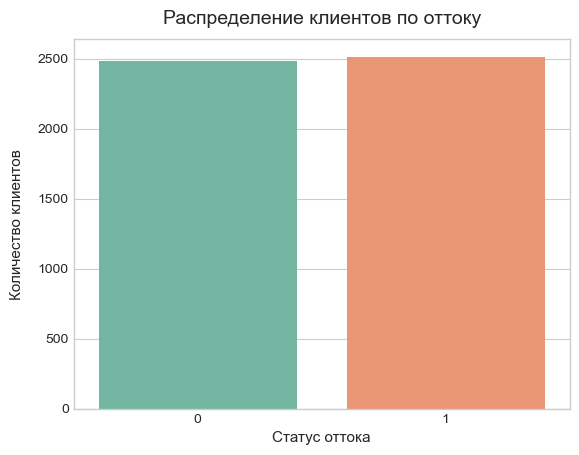

In [571]:
sns.countplot(data=df, x=df['churned'], palette='Set2')
plt.xlabel('Статус оттока', fontsize=11)  # Подпись оси X
plt.ylabel('Количество клиентов', fontsize=11, labelpad=10) 
plt.title('Распределение клиентов по оттоку', fontsize=14, pad=11)
plt.show()

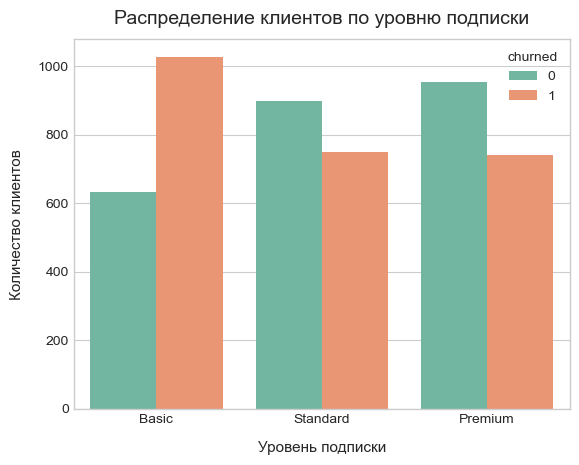

In [572]:
sns.countplot(data=df, hue=df['churned'], x=df['subscription_type'], palette='Set2')
plt.xlabel('Уровень подписки', fontsize=11, labelpad=11)  # Подпись оси X
plt.ylabel('Количество клиентов', fontsize=11, labelpad=10) 
plt.title('Распределение клиентов по уровню подписки', fontsize=14, pad=11)
plt.show()

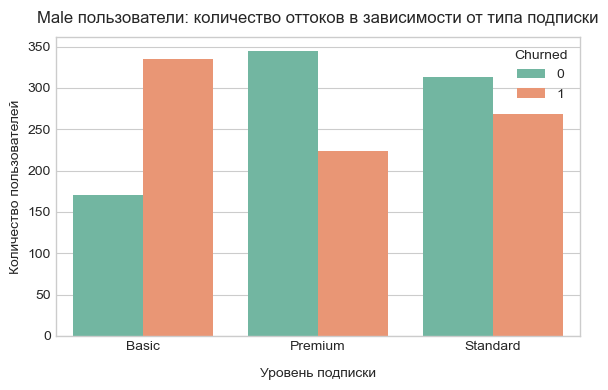

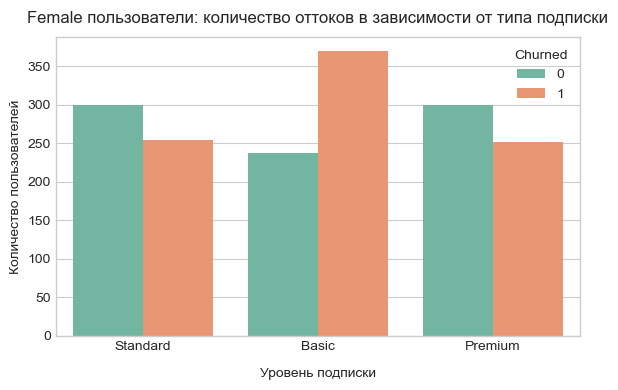

In [573]:
genders = ['Male', 'Female']

for gender in genders:
    plt.figure(figsize=(6, 4))
    subset = df[df['gender'] == gender]
    sns.countplot(
        data=subset,
        x='subscription_type',
        hue='churned',
        palette='Set2'
    )
    plt.title(f"{gender} пользователи: количество оттоков в зависимости от типа подписки", pad=11)
    plt.xlabel("Уровень подписки", labelpad=11)
    plt.ylabel("Количество пользователей")
    plt.legend(title="Churned")
    plt.tight_layout()
    plt.show()

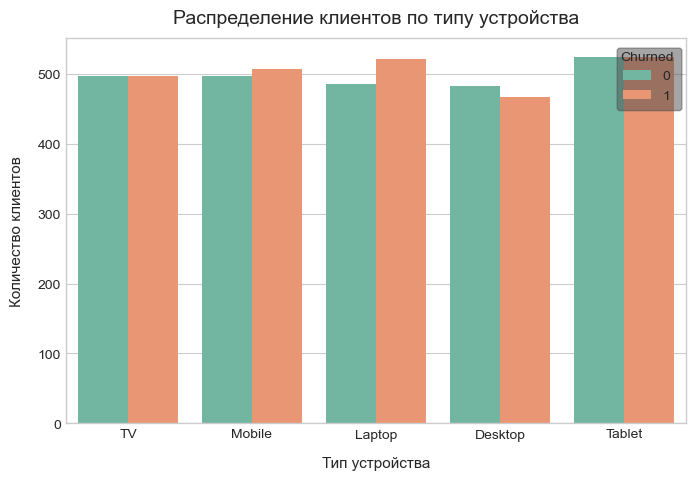

In [574]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x=df['device'], hue=df['churned'], palette='Set2')
plt.xlabel('Тип устройства', fontsize=11, labelpad=11)  # Подпись оси X
plt.ylabel('Количество клиентов', fontsize=11, labelpad=10) 
plt.title('Распределение клиентов по типу устройства', fontsize=14, pad=11)
plt.legend(title='Churned', frameon=True, fancybox=True, shadow=True, framealpha=0) 
plt.show()

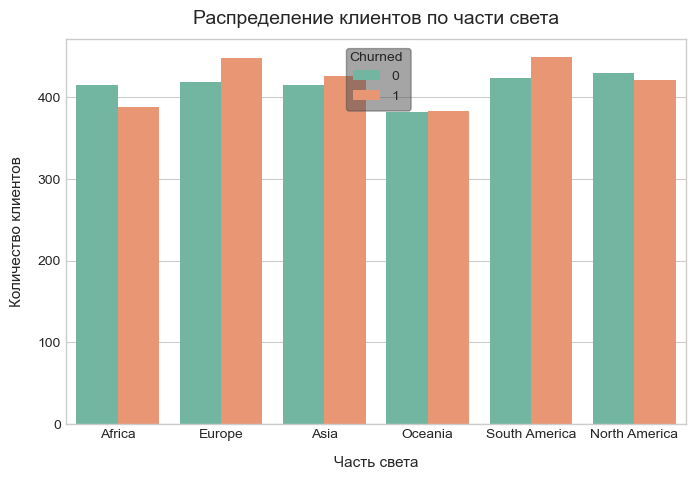

In [575]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df,x=df['region'],hue=df['churned'],palette='Set2')
plt.xlabel('Часть света', fontsize=11, labelpad=11)  # Подпись оси X
plt.ylabel('Количество клиентов', fontsize=11, labelpad=10) 
plt.title('Распределение клиентов по части света', fontsize=14, pad=11)
plt.legend(title='Churned', frameon=True, fancybox=True, shadow=True, framealpha=0) 
plt.show()

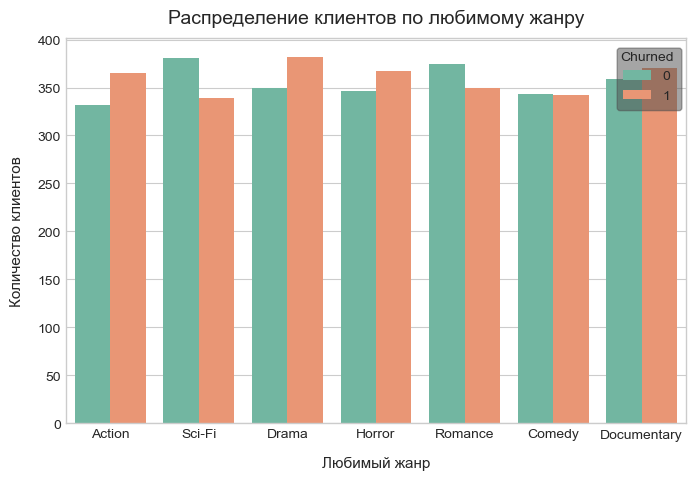

In [576]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x=df['favorite_genre'], hue=df['churned'], palette='Set2')
plt.xlabel('Любимый жанр', fontsize=11, labelpad=11)  # Подпись оси X
plt.ylabel('Количество клиентов', fontsize=11, labelpad=10) 
plt.title('Распределение клиентов по любимому жанру', fontsize=14, pad=11)
plt.legend(title='Churned', frameon=True, fancybox=True, shadow=True, framealpha=0) 
plt.show()

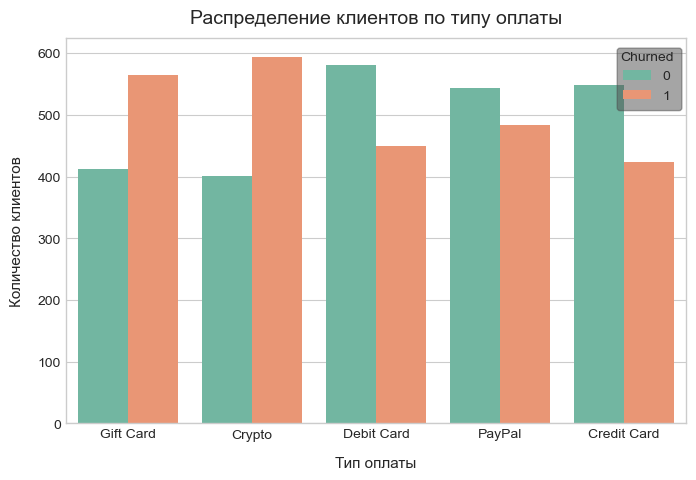

In [579]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x=df['payment_method'], hue=df['churned'], palette='Set2')
plt.xlabel('Тип оплаты', fontsize=11, labelpad=11)  # Подпись оси X
plt.ylabel('Количество клиентов', fontsize=11, labelpad=10) 
plt.title('Распределение клиентов по типу оплаты', fontsize=14, pad=11)
plt.legend(title='Churned', frameon=True, fancybox=True, shadow=True, framealpha=0) 
plt.show()

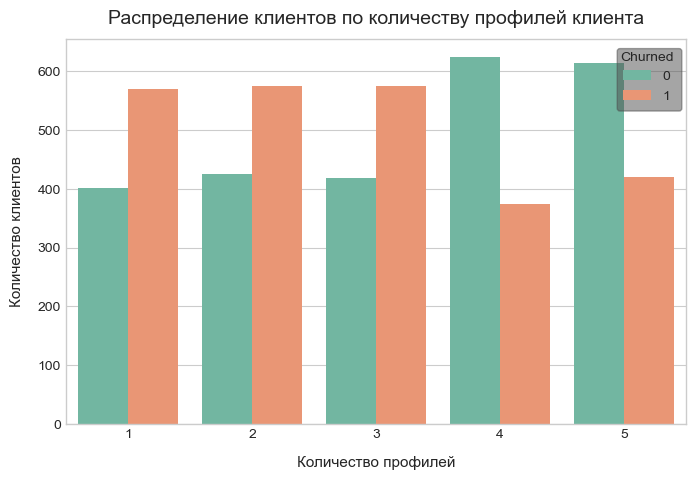

In [580]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x=df['number_of_profiles'], hue=df['churned'], palette='Set2')
plt.xlabel('Количество профилей', fontsize=11, labelpad=11)  # Подпись оси X
plt.ylabel('Количество клиентов', fontsize=11, labelpad=10) 
plt.title('Распределение клиентов по количеству профилей клиента', fontsize=14, pad=11)
plt.legend(title='Churned', frameon=True, fancybox=True, shadow=True, framealpha=0) 
plt.show()

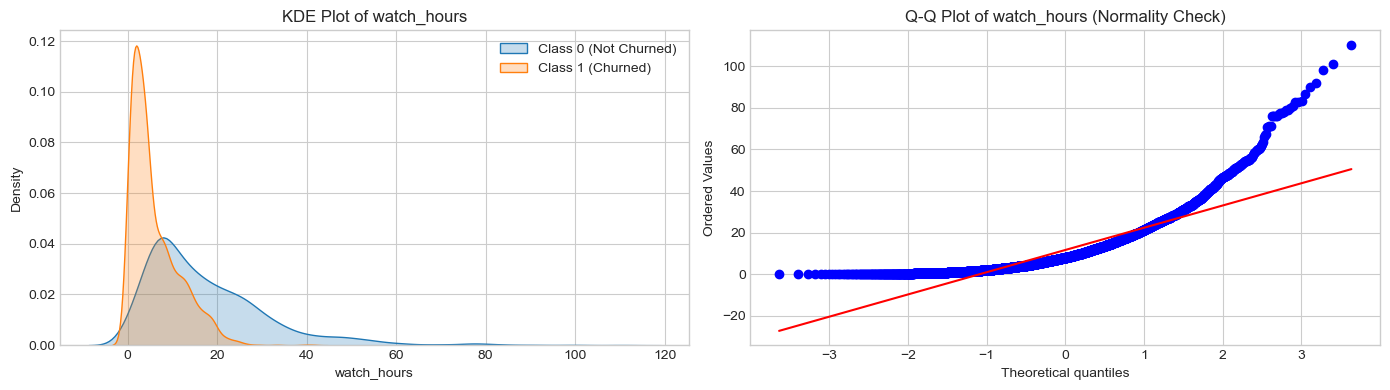

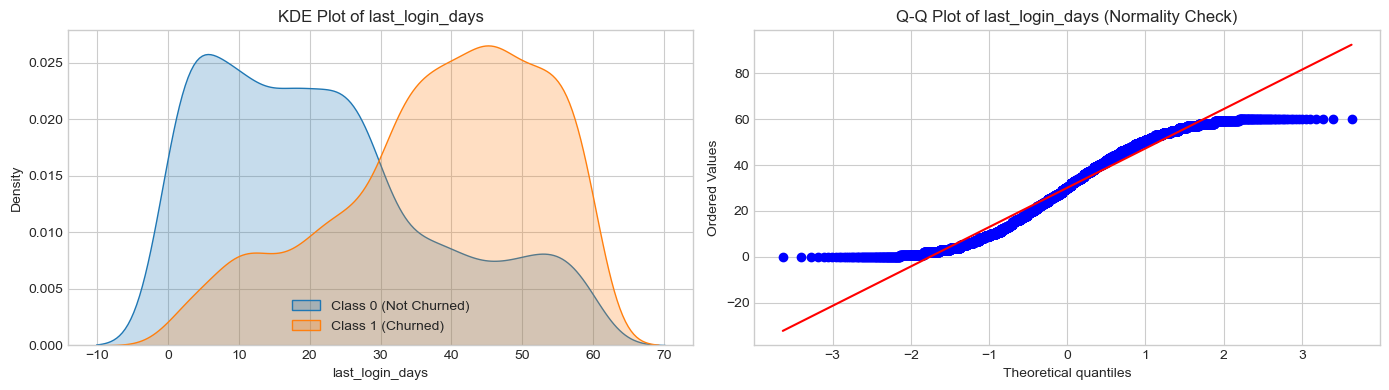

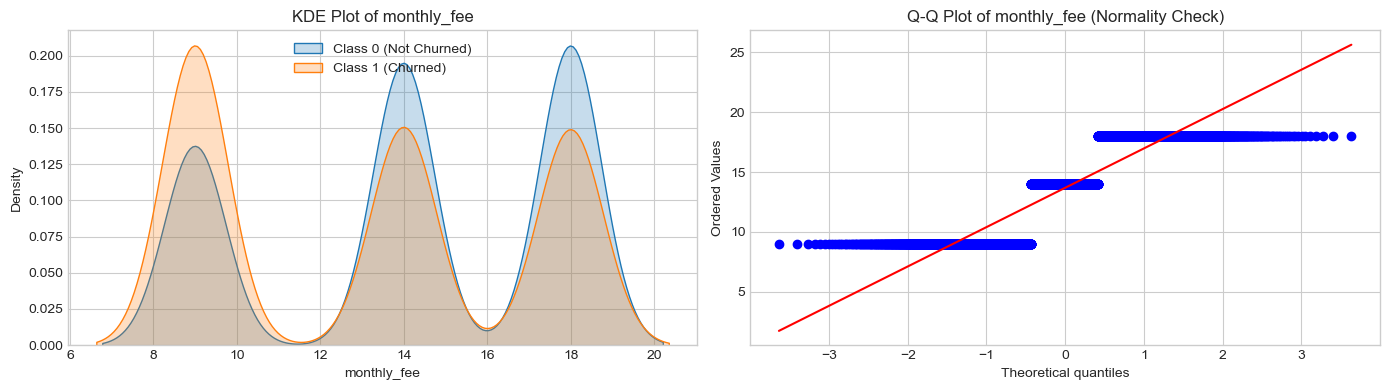

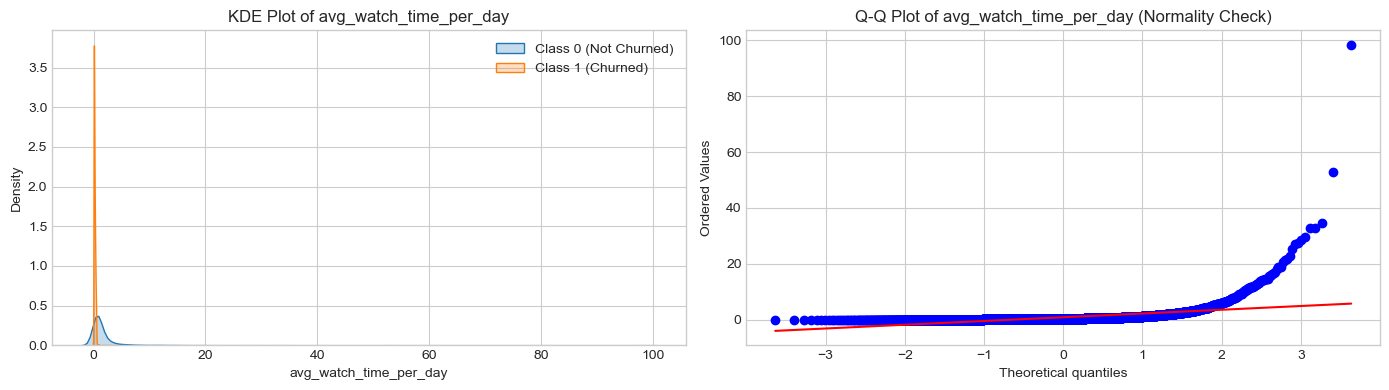

In [581]:
num_features = ['watch_hours', 'last_login_days', 'monthly_fee', 'avg_watch_time_per_day']

for col in num_features:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    sns.kdeplot(data=df[df['churned'] == 0], x=col, label='Class 0 (Not Churned)', fill=True, ax=axes[0])
    sns.kdeplot(data=df[df['churned'] == 1], x=col, label='Class 1 (Churned)', fill=True, ax=axes[0])
    axes[0].set_title(f'KDE Plot of {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Density')
    axes[0].legend()

    stats.probplot(df[col].dropna(), dist="norm", plot=axes[1])
    axes[1].set_title(f'Q-Q Plot of {col} (Normality Check)')

    plt.tight_layout()
    plt.show()

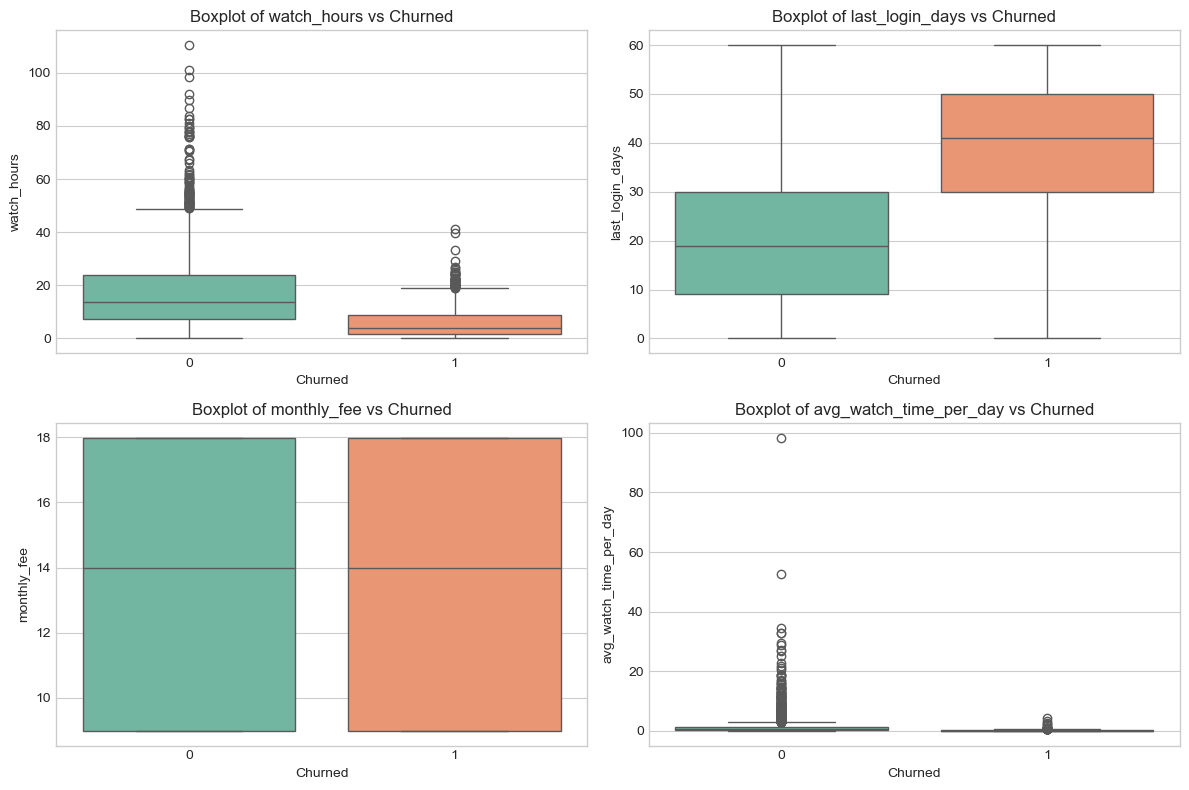

In [583]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(num_features):
    sns.boxplot(data=df, x='churned', y=col, palette='Set2', ax=axes[i])
    axes[i].set_title(f'Boxplot of {col} vs Churned')
    axes[i].set_xlabel('Churned')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

In [584]:
ordinal_order = [['Basic', 'Standard', 'Premium']]
oe = OrdinalEncoder(categories=ordinal_order)
df['subscription_type'] = oe.fit_transform(df[['subscription_type']])

categorical_cols = ['gender','region', 'device', 'payment_method', 'favorite_genre']

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Convert all dummy columns to int (0/1)
dummy_cols = [col for col in df.columns if any(cat in col for cat in categorical_cols)]
df[dummy_cols] = df[dummy_cols].astype(int)
df

,age,subscription_type,watch_hours,last_login_days,monthly_fee,churned,number_of_profiles,avg_watch_time_per_day,gender_Male,gender_Other,region_Asia,region_Europe,region_North America,region_Oceania,region_South America,device_Laptop,device_Mobile,device_TV,device_Tablet,payment_method_Crypto,payment_method_Debit Card,payment_method_Gift Card,payment_method_PayPal,favorite_genre_Comedy,favorite_genre_Documentary,favorite_genre_Drama,favorite_genre_Horror,favorite_genre_Romance,favorite_genre_Sci-Fi
0,51,0.0,14.73,29,8.99,1,1,0.49,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
1,47,1.0,0.70,19,13.99,1,5,0.03,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
2,27,1.0,16.32,10,13.99,0,2,1.48,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0
3,53,2.0,4.51,12,17.99,1,2,0.35,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
4,56,1.0,1.89,13,13.99,1,2,0.13,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,19,0.0,49.17,11,8.99,0,4,4.10,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4996,67,0.0,9.24,2,8.99,0,3,3.08,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
4997,66,1.0,16.55,49,13.99,1,2,0.33,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4998,59,0.0,9.12,3,8.99,0,4,2.28,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


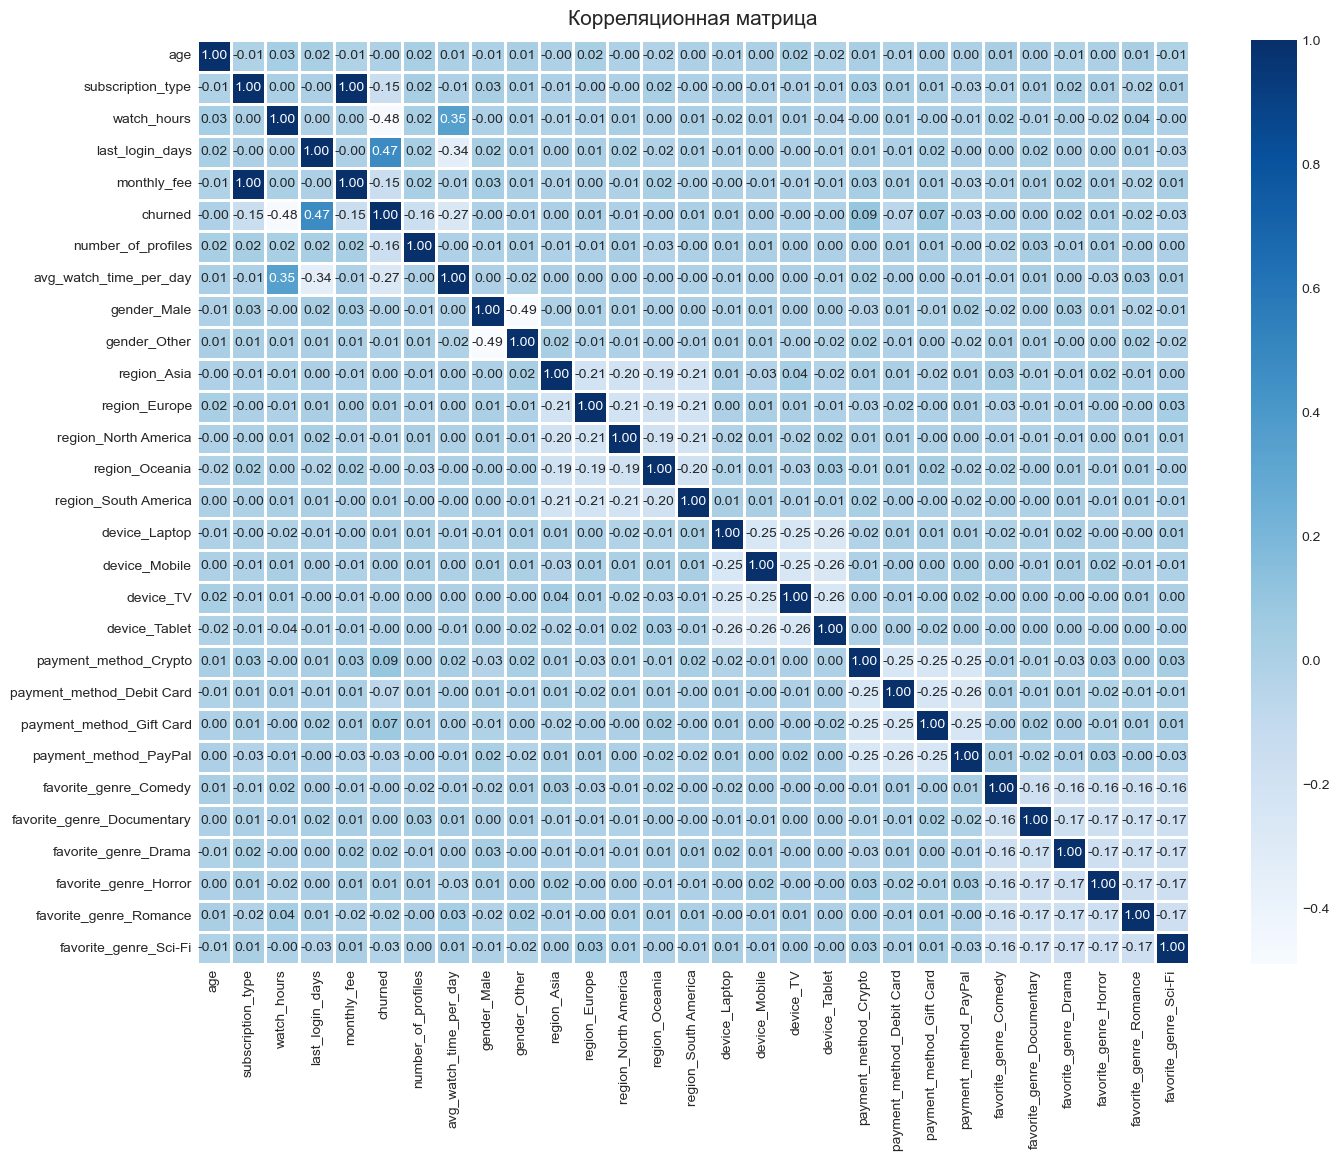

In [599]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap='Blues', annot=True, fmt='.2f', linewidths=2)
plt.title('Корреляционная матрица', fontsize=15, pad=11)
plt.show()

In [601]:
%%time
X = df.drop(columns=['churned'])
y = df['churned']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rfc = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [None, 1, 2, 3, 5],
    'min_samples_leaf': [None, 1, 2, 3, 5],
}

grid_search = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

y_pred = grid_search.predict(X_test)
print('\n\nClassification report:\n')
print(classification_report(y_test, y_pred))

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
Best CV Score: 0.9792500000000001
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       498
           1       0.98      0.97      0.98       502

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

CPU times: total: 8.86 s
Wall time: 5min 29s


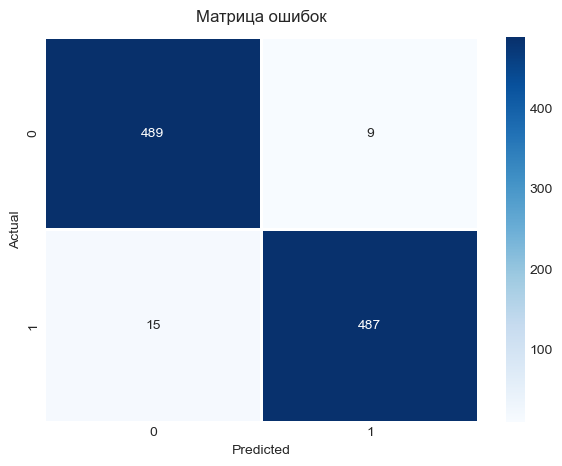

In [611]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2)
plt.title('Матрица ошибок', pad=11)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

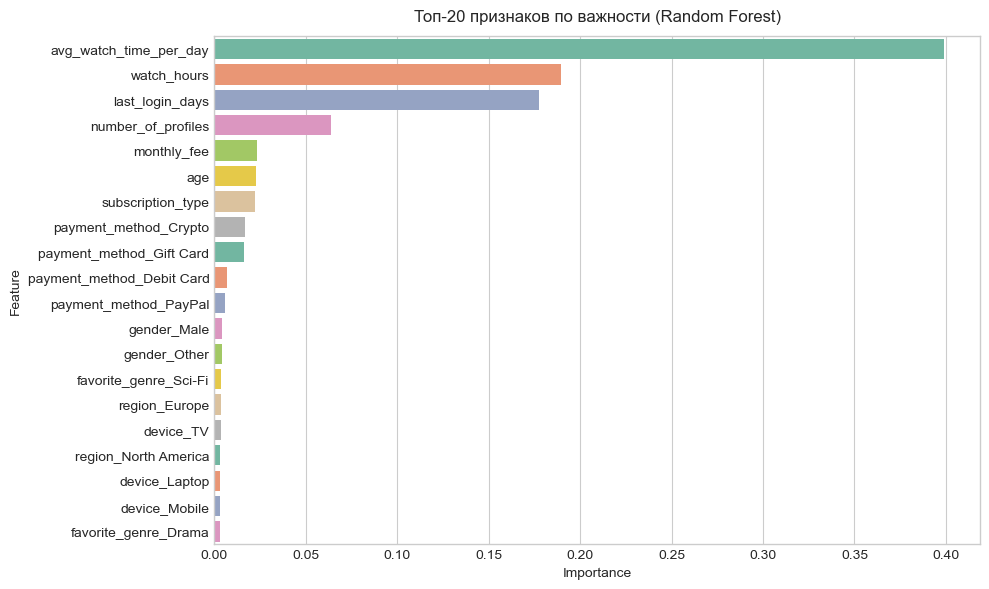

In [621]:
feature_names = X_train.columns

importances = grid_search.best_estimator_.feature_importances_

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(20), x='Importance', y='Feature', palette='Set2')
plt.title('Топ-20 признаков по важности (Random Forest)', pad=11)
plt.tight_layout()
plt.show()